# Model

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import seaborn as sns

from math import sqrt

# Function for splitting training and test set
from sklearn.model_selection import train_test_split

# Function to perform data standardization 
from sklearn.preprocessing import StandardScaler

# Libraries to perform hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Import classes for ML Models
from sklearn.linear_model import Ridge  ## Linear Regression + L2 regularization
from sklearn.svm import SVR ## Support Vector Regressor
from sklearn.ensemble import RandomForestRegressor ## Random Forest Regressor
from sklearn.neighbors import KNeighborsRegressor ## KNN regressor
from sklearn.tree import DecisionTreeRegressor ## Decision Tree Regressor
from sklearn import linear_model ## Lasso Regressor
from sklearn.linear_model import Lasso

# Evaluation Metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae

# To save the final model on disk
from sklearn.externals import joblib
#standard scalar

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.shape

(550068, 12)

# Data Preprocessing

In [5]:
df.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

we will replace Product_Category_2 NAN values with appropriate mean values according to respective age category <br>
and fill null values in product_category_3 with 0.

In [6]:
col=[df['Product_Category_2'],df['Age']]

In [7]:
def impute_2(col):
    age=col[1]
    product_Category_2=col[0]
    
    if pd.isnull(product_Category_2):
        if age=='0-17':
            return 8
        elif age=='55+':
            return 12
        elif age=='26-35':
            return 9
        elif age=='46-50':
            return 11
        elif age=='51-55':
            return 11
        elif age=='36-45':
            return 10
        else:
            return 8
    else:
        return product_Category_2

In [8]:
df['Product_Category_2']=df[['Product_Category_2','Age']].apply(impute_2,axis=1)

In [9]:
df.Product_Category_3.fillna(0, inplace=True)

In [10]:
# Converting Product_Category_2 and Product_Category_3 to int from object, to maintain consistency across the dataframe
df['Product_Category_2'] = df['Product_Category_2'].astype(int)
df['Product_Category_3'] = df['Product_Category_3'].astype(int)

In [11]:
df.isnull().sum()

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Product_Category_3            0
Purchase                      0
dtype: int64

So  we removed all null values

Now, we need to find new features out of old one to extract key information 

In [12]:
#In Gender, replacing 'F' with 0 and 'M' with 1
df.loc[df['Gender'] == 'F', 'Gender'] = 0
df.loc[df['Gender'] == 'M', 'Gender'] = 1

In [13]:
#In Age column, replacing different ranges with the below values.
def agegroup(x):
    if x=='0-17':
        return 0
    elif x=='18-25':
        return 1
    elif x ==  "26-35" :
        return 2
    elif x ==  "36-45" :
        return 3
    elif x ==  "46-50" :
        return 4
    elif x ==  "51-55" :
        return 5
    elif x ==  "55+" :
        return 6
    
df['AgeGroup']=df['Age'].map(agegroup)

In [14]:
df.drop(['Age'],axis=1,inplace=True)

In [15]:
# In 'Stay_In_Current_City_Years', replacing '4+' with 4
df.loc[df['Stay_In_Current_City_Years'] == '4+', 'Stay_In_Current_City_Years'] = 4

In [16]:
# In 'City_Category',replacing different categories with the values 0, 1, 2 respectively.
df.loc[df['City_Category'] == 'A', 'City_Category'] = 0
df.loc[df['City_Category'] == 'B', 'City_Category'] = 1
df.loc[df['City_Category'] == 'C', 'City_Category'] = 2

In [17]:
# Converting all object type columns to integer to maintain consistency across the dataframe
df['Gender'] = df['Gender'].astype(int)
df['AgeGroup'] = df['AgeGroup'].astype(int)
df['City_Category'] = df['City_Category'].astype(int)
df['Stay_In_Current_City_Years'] = df['Stay_In_Current_City_Years'].astype(int)

In [18]:
df.head()

,User_ID,Product_ID,Gender,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,AgeGroup
0,1000001,P00069042,0,10,0,2,0,3,8,0,8370,0
1,1000001,P00248942,0,10,0,2,0,1,6,14,15200,0
2,1000001,P00087842,0,10,0,2,0,12,8,0,1422,0
3,1000001,P00085442,0,10,0,2,0,12,14,0,1057,0
4,1000002,P00285442,1,16,2,4,0,8,12,0,7969,6


In [19]:
# corr indicates the correlation between all the features of the dataset. 
#positive correlation means two qunatities are directly proportinal While negative means inversely proportional.
df.corr()

,User_ID,Gender,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,AgeGroup
User_ID,1.000000,-0.033474,-0.023971,0.022859,-0.030737,0.020443,0.003825,0.004642,0.003605,0.004716,0.032698
Gender,-0.033474,1.000000,0.117291,-0.004515,0.014660,-0.011603,-0.045594,-0.015350,0.036146,0.060346,-0.004262
Occupation,-0.023971,0.117291,1.000000,0.034479,0.030005,0.024280,-0.007618,0.008098,0.012269,0.020833,0.091463
City_Category,0.022859,-0.004515,0.034479,1.000000,0.019946,0.039790,-0.014364,0.003770,0.035525,0.061914,0.123079
Stay_In_Current_City_Years,-0.030737,0.014660,0.030005,0.019946,1.000000,-0.012819,-0.004213,-0.001090,0.001977,0.005422,-0.004712
Marital_Status,0.020443,-0.011603,0.024280,0.039790,-0.012819,1.000000,0.019888,0.037026,-0.004629,-0.000463,0.311738
Product_Category_1,0.003825,-0.045594,-0.007618,-0.014364,-0.004213,0.019888,1.000000,0.355560,-0.385534,-0.343703,0.061197
Product_Category_2,0.004642,-0.015350,0.008098,0.003770,-0.001090,0.037026,0.355560,1.000000,-0.291855,-0.164070,0.124851
Product_Category_3,0.003605,0.036146,0.012269,0.035525,0.001977,-0.004629,-0.385534,-0.291855,1.000000,0.288501,-0.007422
Purchase,0.004716,0.060346,0.020833,0.061914,0.005422,-0.000463,-0.343703,-0.164070,0.288501,1.000000,0.015839


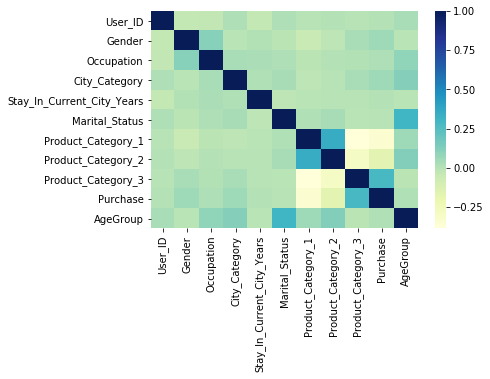

In [20]:
#correlation heatmap
sns.heatmap(data=df.corr(), cmap="YlGnBu")

Now we need to build validation set to calculete error for different methods.
For this, we will divide test data 80:20.

In [21]:
# Create separate object for target variable
Y = df['Purchase']
# Create separate object for input features
X = df.drop(['Purchase','Product_ID'], axis=1)

In [22]:
X_train, X_validate, y_train, y_validate = train_test_split(X, Y, test_size=0.2, random_state=123412)

In [23]:
#standardization
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_validate = sc_X.transform(X_validate)


In [24]:
print(X_train.shape, X_validate.shape, y_train.shape, y_validate.shape)

(440054, 10) (110014, 10) (440054,) (110014,)


# Lasso Regression

In [25]:
# training the model with hyparameters alpha=0.3 and normalize=True
lassoReg = Lasso(alpha=0.3, normalize=True)
lassoReg.fit(X_train,y_train)

# outputs an array of purchase amounts
predictions = lassoReg.predict(X_validate)

#finalsolution = Test[['User_ID','Product_ID']]
#finalsolution['Purchase'] = predictions



In [26]:
print("Train Results for Lasso Regression:")
print("Root mean squared error: ", sqrt(mse(predictions, y_validate)))
print("R-squared: ", r2_score(predictions, y_validate))
print("Mean Absolute Error: ", mae(predictions, y_validate))

Train Results for Lasso Regression:
Root mean squared error:  4656.961693351729
R-squared:  -6.603999014527048
Mean Absolute Error:  3557.642483907875


# Ridge Regression

In [27]:
# training the model with hyperparameters alpha=0.05 and normalize=True
ridgeReg = Ridge(alpha=0.05, normalize=True)
ridgeReg.fit(X_train,y_train)

# predicts the purchase amounts and outputs an array
predictions = ridgeReg.predict(X_validate)


In [28]:
print("Train Results for Ridge Regression:")
print("Root mean squared error: ", sqrt(mse(predictions, y_validate)))
print("R-squared: ", r2_score(predictions, y_validate))
print("Mean Absolute Error: ", mae(predictions, y_validate))

Train Results for Ridge Regression:
Root mean squared error:  4640.845622292619
R-squared:  -5.004494123128955
Mean Absolute Error:  3543.1861152943666


# Linear Regression

In [29]:
from sklearn import linear_model

In [30]:
regr = linear_model.LinearRegression(normalize=True)

In [31]:
regr

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [32]:
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [33]:
predictions = regr.predict(X_validate)

In [34]:
print("Train Results for Linar Regression:")
print("Root mean squared error: ", sqrt(mse(predictions, y_validate)))
print("R-squared: ", r2_score(predictions, y_validate))
print("Mean Absolute Error: ", mae(predictions, y_validate))

Train Results for Linar Regression:
Root mean squared error:  4640.040640798236
R-squared:  -4.601589065048443
Mean Absolute Error:  3536.2780278046935


# Random Forest

In [35]:
rf = RandomForestRegressor()

In [36]:
rf.fit(X_train,y_train)

C:\Users\Hrishikesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [37]:
predictions = rf.predict(X_validate)

In [38]:
print("Train Results for Random Forest Regression:")
print("Root mean squared error: ", sqrt(mse(predictions, y_validate)))
print("R-squared: ", r2_score(predictions, y_validate))
print("Mean Absolute Error: ", mae(predictions, y_validate))

Train Results for Random Forest Regression:
Root mean squared error:  3033.2652347794583
R-squared:  0.5238956212676309
Mean Absolute Error:  2191.179199256062


# Extreme Gradient Boosting

In [39]:
import xgboost

In [40]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,colsample_bytree=1, max_depth=7)

In [41]:
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.08, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.75,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [42]:
predictions = xgb.predict(X_validate)

In [43]:
print("Train Results for XG boost:")
print("Root mean squared error: ", sqrt(mse(predictions, y_validate)))
print("R-squared: ", r2_score(predictions, y_validate))
print("Mean Absolute Error: ", mae(predictions, y_validate))

Train Results for XG boost:
Root mean squared error:  2865.66108508755
R-squared:  0.49789960933714894
Mean Absolute Error:  2152.7188869600395


# Elastic Net Regression

In [44]:
from sklearn.linear_model import ElasticNet
# training the model with hyperparameters alpha=1, l1_ratio=0.5 and normalize=True
ENreg = ElasticNet(alpha=1, l1_ratio=0.5, normalize=False)
ENreg.fit(X_train,y_train)

# predicts the purchase amounts and outputs an array
predictions = ENreg.predict(X_validate)

In [45]:
print("Train Results for Elastic Net Regression:")
print("Root mean squared error: ", sqrt(mse(predictions, y_validate)))
print("R-squared: ", r2_score(predictions, y_validate))
print("Mean Absolute Error: ", mae(predictions, y_validate))

Train Results for Elastic Net Regression:
Root mean squared error:  4670.00608688571
R-squared:  -9.140451695348432
Mean Absolute Error:  3608.245239463114


# Extra Trees Regresser

In [46]:
from sklearn.ensemble import ExtraTreesRegressor

eTreeReg = ExtraTreesRegressor(n_estimators=10)
eTreeReg.fit(X_train,y_train)

predictions = eTreeReg.predict(X_validate)

In [47]:
print("Train Results Extra Trees Regression:")
print("Root mean squared error: ", sqrt(mse(predictions, y_validate)))
print("R-squared: ", r2_score(predictions, y_validate))
print("Mean Absolute Error: ", mae(predictions, y_validate))

Train Results Extra Trees Regression:
Root mean squared error:  3173.557291515215
R-squared:  0.506401103452055
Mean Absolute Error:  2251.740379249947


# Support Vector Machine

In [ ]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)
predictions = clf.predict(X_validate)

In [ ]:
print("Train Results Support vector machine(SVM):")
print("Root mean squared error: ", sqrt(mse(predictions, y_validate)))
print("R-squared: ", r2_score(predictions, y_validate))
print("Mean Absolute Error: ", mae(predictions, y_validate))

# K Nearest Neighbour

In [48]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
predictions = neigh.predict(X_validate)              

In [49]:
print("Train Results for KNN:")
print("Root mean squared error: ", sqrt(mse(predictions, y_validate)))
print("R-squared: ", r2_score(predictions, y_validate))
print("Mean Absolute Error: ", mae(predictions, y_validate))

Train Results for KNN:
Root mean squared error:  4976.517934184421
R-squared:  -0.6212083028507565
Mean Absolute Error:  3485.964649953642
